# Navigation Control - Double Deep Q-Networks (Double DQN)

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment

import numpy as np

import torch

from agent import Agent
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe", no_graphics=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents in the environment
print('Number of agents:', len(env_info.agents))
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Agent Setup

In [4]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self, state_size, actions_size, fc1_units=64):
        super().__init__()                
        
        self.fc1 = nn.Linear(state_size, fc1_units)        
        self.fcO = nn.Linear(fc1_units, actions_size)
                
    def forward(self, x):        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fcO(x)
        
        return x

    
from recordtype import recordtype
from collections import deque

class ReplayMemory:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device = 'cpu'):
        """Initialize a ReplayBuffer object.

        Params
        ======        
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """

        self.DEVICE = device
        
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size        
        self.experience = recordtype('Experience', ["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.DEVICE)        
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)



import os
import torch.optim as optim
from model import Model
from replay_memory import ReplayMemory

class Agent():

    def __init__(self, 
            device,
            state_size, actions_size,
            alpha, gamma, TAU, update_every, buffer_size, batch_size, LR,
            CHECKPOINT_FOLDER = './'):
        
        self.DEVICE = device

        self.state_size = state_size
        self.actions_size = actions_size

        self.ALPHA = alpha
        self.GAMMA = gamma
        self.TAU = TAU
        self.UPDATE_EVERY = update_every
        self.BUFFER_SIZE = buffer_size
        self.BATCH_SIZE = batch_size
        self.LR = LR

        self.CHECKPOINT_FOLDER = CHECKPOINT_FOLDER
    

        self.model = Model(state_size, actions_size).to(self.DEVICE)
        self.target_model = Model(state_size, actions_size).to(self.DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.LR)
        
        if os.path.isfile('checkpoint.pth'):
            self.model.load_state_dict(torch.load('checkpoint.pth'))
            self.target_model.load_state_dict(torch.load('checkpoint.pth'))

        self.memory = ReplayMemory(self.BUFFER_SIZE, self.BATCH_SIZE, self.DEVICE)

        self.t_step = 0
    
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.DEVICE)
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(state)
        self.model.train()
                
        if np.random.uniform() < eps:
            return random.choice(np.arange(self.actions_size))            
        else:
            action = np.argmax(action_values.cpu().data.numpy())
            return action
            
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):        
        states, actions, rewards, next_states, dones = experiences        

        Q_targets_next = self.target_model(next_states).detach().max(1)[0].unsqueeze(1)
        Q_target = self.ALPHA * (rewards + self.GAMMA * Q_targets_next * (1 - dones))

        Q_value = self.model(states).gather(1, actions)
                
        loss = F.smooth_l1_loss(Q_value, Q_target)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target model
        self.soft_update_target_model()

    def soft_update_target_model(self):
        for target_param, local_param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data)

    def checkpoint(self):        
        torch.save(self.model.state_dict(), self.CHECKPOINT_FOLDER + 'checkpoint.pth')

### 4. Train Agent

In [5]:
# hyperparameters
ALPHA = 1
GAMMA = 0.99
TAU = 1e-3
UPDATE_EVERY = 1
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
LR = 5e-4

CHECKPOINT_FOLDER = './'

agent = Agent(DEVICE, state_size, action_size, ALPHA, GAMMA, TAU, UPDATE_EVERY, BUFFER_SIZE, BATCH_SIZE, LR, CHECKPOINT_FOLDER) 

Episode: 	232 	Score: 	23.00 	Average Score: 	13.09
Environment solved in 232 episodes!	Average Score: 13.09


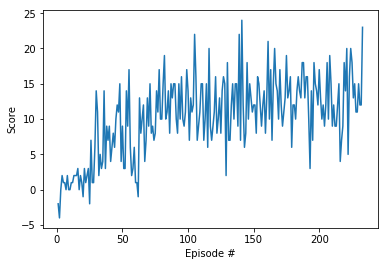

In [6]:
def ddqn_train():

    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 1000
    for episode in range(0, n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        while True:        
            action = int(agent.act(state, 0.05))
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            
            agent.step(state, action, reward, next_state, done)        

            state = next_state                             # roll over the state to next time step        
            if done:                                       # exit loop if episode finished
                break
        
        agent.checkpoint()

        scores.append(score)
        scores_window.append(score)
        
        print('\rEpisode: \t{} \tScore: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, score, np.mean(scores_window)), end="")  

        if np.mean(scores_window) >= 13 and episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))                
            break
        
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()    


# train the agent
ddqn_train()

### 5. Test the Agent

In [7]:
agent = Agent(
                DEVICE,
                state_size, action_size,
                ALPHA, GAMMA, TAU, UPDATE_EVERY, BUFFER_SIZE, BATCH_SIZE, LR,
                CHECKPOINT_FOLDER
        ) 

for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state     
    score = 0                                   

    while True:        
        action = int(agent.act(state))

        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state       
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished       
        score += reward         

        state = next_state                             # roll over the state to next time step        

        if done:                                       # exit loop if episode finished
            break
    
    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, score))

Episode: 	0 	Score: 	5.00
Episode: 	1 	Score: 	1.00
Episode: 	2 	Score: 	3.00


In [8]:
env.close()